# Performance
In this notebook we test the performance and network usage complexity of the algorithm.

In [2]:
import matplotlib.pyplot as plt

from generator import generate_nodes
import numpy as np

## Errors

In [22]:
n = [10_000, 100_000, 1_000_000]
data = [np.random.standard_normal(n_) for n_ in n]
sorted_data = [np.sort(arr) for arr in data]
k = [50, 100, 1000]
h = [3, 5, 10]
q = [0.01, 0.05, 0.1, 0.5, 0.9, 0.95, 0.99]
errs = []
eps = 0.0001

In [23]:
for i, data_ in enumerate(data):
    n_ = len(data_)
    for k_ in k:
        for h_ in h:
            network, root, _, height = generate_nodes(n_, k_, h_, data_, graph_partition=True)
            root.new_task(eps)
            for q_ in q:
                rank = int(q_ * n_)
                res = root.rank_query(rank)
                errs.append(np.abs(np.where(sorted_data[i] == res)[0][0] - rank) / n_)

avg_error = np.sum(errs) / len(errs)

In [24]:
avg_error

0.00045577248677248675

## Network Communication Cost



In [25]:
import numpy as np
from generator import generate_nodes
from tqdm import tqdm
import matplotlib.pyplot as plt

In [27]:
epss = np.logspace(-4, -2, 30)
epss_stat = np.zeros_like(epss)
ks = np.linspace(128, 2048, 30).astype(int)
ks_stat = np.zeros_like(ks, dtype=float)
hs = np.linspace(4, 64, 30).astype(int)
hs_stat = np.zeros_like(hs, dtype=float)
q = 0.25
n = 1_000_000
repetitions = 30

split_deviation = 0.0 #n // 10
rank = q * n

In [28]:
print("Generating random data")
data = np.random.standard_normal(n)

print("Sorting the data")
sorted_data = np.sort(data)

Generating random data
Sorting the data


Started testing number of nodes (k) in the network


30it [07:46, 15.54s/it]


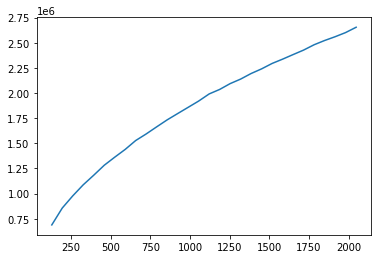

In [29]:
print("Started testing number of nodes (k) in the network")
for i, k in tqdm(enumerate(ks)):
    for _ in range(repetitions):
        network, root, data, height = generate_nodes(n, k, 8, data, split_deviation=split_deviation, graph_partition=True)
        network.reset()

        root.new_task(epss[0])
        value, rank = root.rank_query(rank, return_rank=True)
        ks_stat[i] += network.non_system_stats
        # print(network.stat)
ks_stat /= repetitions

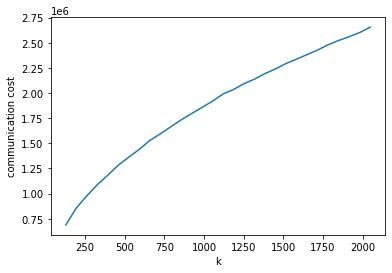

In [32]:
plt.plot(ks, ks_stat)
plt.xlabel('k')
plt.ylabel('communication cost')
plt.show()

In [33]:
ks_stat[-1]/ks_stat[0]


3.8553198541035827

In [34]:
print("Started testing height of the tree (h) in the network")
for i, h in tqdm(enumerate(hs)):
    for _ in range(repetitions):
        network, root, data, height = generate_nodes(n, 256, h, data, split_deviation=split_deviation, graph_partition=True)
        network.reset()

        root.new_task(epss[0])
        value, rank = root.rank_query(rank, return_rank=True)
        hs_stat[i] += network.non_system_stats
        # print(network.stat)
hs_stat /= repetitions

Started testing number of nodes (k) in the network


30it [03:15,  6.52s/it]


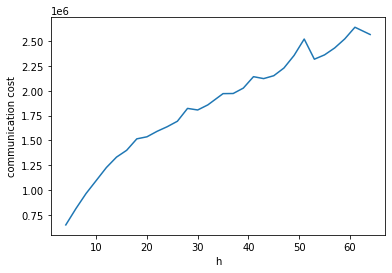

In [35]:
plt.plot(hs, hs_stat)
plt.xlabel('h')
plt.ylabel('communication cost')
plt.show()

In [36]:
hs_stat[-1]/hs_stat[0]


3.9292261665047117

In [37]:
print("Started testing error (eps)")
for i, eps in tqdm(enumerate(epss)):
    for _ in range(repetitions):
        network, root, data, height = generate_nodes(n, 1024, 16, data, split_deviation=split_deviation, graph_partition=True)
        network.reset()

        root.new_task(eps)
        value, rank = root.rank_query(rank, return_rank=True)
        epss_stat[i] += network.non_system_stats
        # print(network.stat)
epss_stat /= repetitions

Started testing error (eps)


30it [03:54,  7.83s/it]


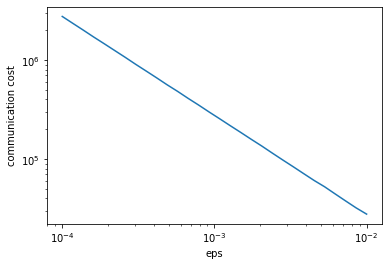

In [40]:
plt.plot(epss, epss_stat)
plt.xlabel('eps')
plt.ylabel('communication cost')
plt.yscale("log")
plt.xscale("log")
plt.show()

In [41]:
epss_stat[-1]/epss_stat[0]

0.010064684976656487

## Conclusion
It was not a lie! The algorithm is working with $O(\sqrt{kh} / \epsilon)$ total communication complexity!